<a href="https://www.kaggle.com/code/luochenxun/learn2?scriptVersionId=124580743" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 使用逻辑回归解决二元分类问题

## 1.1. 读取数据



In [1]:
import numpy as np
import pandas as pd
df_heart = pd.read_csv('/kaggle/input/learn-heart/heart.csv')
df_heart.head()
# 其中 age, sex..等为特征值，target 表示此人是否有心脏疾病。

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [2]:
# 打印标签值统计结果，逻辑回归适合结果是比较均匀的，我们可以看到，其中有疾病和无病的比较几乎1比1
df_heart.target.value_counts()

1    165
0    138
Name: target, dtype: int64

打印标签值统计结果，逻辑回归适合结果是比较均匀的，我们可以看到，其中有疾病和无病的比较几乎1比1。



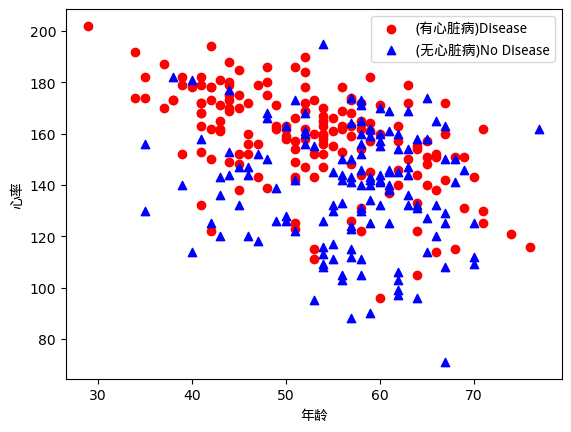

In [3]:
import matplotlib
import matplotlib.pyplot as plt
# --- matplot 中文支持
myfont = matplotlib.font_manager.FontProperties(fname="/kaggle/input/droidsansfallback/DroidSansFallback.ttf")
plt.rcParams['font.family'] = ['DejaVu Sans']# 用来正常显示中文标签 
plt.rcParams["axes.unicode_minus"] = False # 该语句解决图像中的“-”负号的乱码问题
# --- end of 中文支持
plt.scatter(x=df_heart.age[df_heart.target==1],
            y=df_heart.thalach[(df_heart.target==1)], 
            c='red')
plt.scatter(x=df_heart.age[df_heart.target==0],
            y=df_heart.thalach[(df_heart.target==0)], 
            marker='^', 
            c='blue')
plt.legend(["(有心脏病)Disease", "(无心脏病)No Disease"], prop=myfont)
plt.xlabel("年龄", fontproperties=myfont)
plt.ylabel("心率", fontproperties=myfont)
plt.show()

输出结果显示出心率（Heart Rate）越高，患心脏病的可能性看起来越大，因为代表患病样本的圆点，多集中在图的上方。

## 1.2. 构建特征集与标签集




### 构造哑特征

通过对数据字段进行分析，数据类型的枚举值会对计算结果造成影响。

我们提到过，如果原始数据是男、女这种字符，首先要转换成0、1数据格式。那么你们再观察像'cp'、'thal'和'slope'这样的数据，它们也都代表类别。比如，cp这个字段，它的意义是“胸痛类型”，取值为0、1、2、3。这些分类值，是大小无关的。

但是问题在于，计算机会把它们理解为数值，认为3比2大，2比1大。这种把“胸痛类型”的类别像“胸部大小”的尺码一样去解读是不科学的，会导致误判。因为这种类别值只是一个代号，它的意义和年龄、身高这种连续数值的意义不同。

解决的方法，是把这种类别特征拆分成多个哑特征，比如cp有0、1、2、3这4类，就拆分成个4特征，cp_0为一个特征、cp_1为一个特征、 cp_2为一个特征、cp_3为一个特征。每一个特征都还原成二元分类，答案是Yes或者No，也就是数值1或0。

> 这个过程是把一个变量转换成多个`哑变量（dummy variable）`，也 叫虚拟变量、名义变量的过程。哑变量用以反映质的属性的一个人工变量，是量化了的质变量，通常取值为0或1。

下面使用`pd.get_dummies()`方法自动将之转成`哑变量（dummy variable）`

In [4]:
# 把3个文本型变量转换为哑变量
a = pd.get_dummies(df_heart['cp'], prefix = 'cp')
b = pd.get_dummies(df_heart['thal'], prefix = 'thal')
c = pd.get_dummies(df_heart['slope'], prefix = 'slope')
# 把哑变量添加进dataframe
frames = [df_heart, a, b, c]
df_heart = pd.concat(frames, axis = 1)
df_heart = df_heart.drop(columns = ['cp', 'thal', 'slope'])
df_heart.head() # 显示新的dataframe





,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,63,1,145,233,1,0,150,0,2.3,0,...,0,0,1,0,1,0,0,1,0,0
1,37,1,130,250,0,1,187,0,3.5,0,...,0,1,0,0,0,1,0,1,0,0
2,41,0,130,204,0,0,172,0,1.4,0,...,1,0,0,0,0,1,0,0,0,1
3,56,1,120,236,0,1,178,0,0.8,0,...,1,0,0,0,0,1,0,0,0,1
4,57,0,120,354,0,1,163,1,0.6,0,...,0,0,0,0,0,1,0,0,0,1


In [5]:
### 构建特征集
# 将数据源中的 target 列去掉（将样本集中的标签集去掉，得特征值）
X = df_heart.drop(['target'], axis=1)
# 取标签集
y = df_heart.target.values
y = y.reshape(-1, 1)
print("张量X的形状：", X.shape)
print("张量y的形状：", y.shape)

### 划分特征集与测试集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

张量X的形状： (303, 21)
张量y的形状： (303, 1)


## 1.3 归一化

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 2. 建立逻辑回归模型



In [7]:
# 首先定义一个Sigmoid函数，输入Z，返回y'
def sigmoid(z):
    y_hat = 1 / (1+np.exp(-z))
    return y_hat

# 然后定义损失函数
def loss_function(X, y, w, b):
    y_hat = sigmoid(np.dot(X, w) + b)
    loss = -(y*np.log(y_hat) + (1-y)*np.log(1-y_hat))
    cost = np.sum(loss) / X.shape[0]
    return cost

# 然后构建梯度下降的函数
def gradient_descent(X, y, w, b, alpha, iterations):
    l_history = np.zeros(iterations)
    w_history = np.zeros((iterations, w.shape[0], w.shape[1]))
    b_history = np.zeros(iterations)
    for i in range(iterations):
        y_hat = sigmoid(np.dot(X, w)+b)
        loss = -(y*np.log(y_hat) + (1-y)*np.log(1-y_hat))
        derivative_w = np.dot(X.T, ((y_hat-y))) / X.shape[0]
        derivative_b = np.sum(y_hat-y) / X.shape[0]
        w = w - alpha * derivative_w
        b = b - alpha * derivative_b
        l_history[i] = loss_function(X, y, w, b)
        if i < 10 or i > (iterations - 10):
            print ("轮次", i+1 , "当前轮训练集损失：",l_history[i]) 
        w_history[i] = w # 梯度下降过程中权重的历史 请注意w_history和w的形状
        b_history[i] = b # 梯度下降过程中偏置的历史
    return l_history, w_history, b_history



## 2.2. 定义预测函数

在训练机器之前，得先预测逻辑回归预测函数。

In [8]:
# 定义预测函数
def predict(X, w, b):
    z = np.dot(X, w) + b
    y_hat = sigmoid(z) # 先用线性回归算出中间值，再利用 sigmoid 得出预测值 y_hat
    y_pred = np.zeros((y_hat.shape[0], 1))
    for i in range(y_hat.shape[0]): # 遍历 y_hat，对概率进行判断，> 0.5 则及格
        if y_hat[i, 0] < 0.5:
            y_pred[i, 0] = 0
        else:
            y_pred[i, 0] = 1
    return y_pred # 返回分类结果

## 3. 训练机器

## 3.1. 逻辑回归模型

In [9]:
def logistic_regression(X, y, w, b, lr, iter): # 定义逻辑回归模型
    l_history, w_history, b_history = gradient_descent(X,y,w,b,lr,iter) # 梯度下降
    print("训练最终损失:", l_history[-1]) # 打印最终损失
    y_pred = predict(X,w_history[-1],b_history[-1]) # 进行预测
    traning_acc = 100 - np.mean(np.abs(y_pred - y_train))*100 # 计算准确率
    print("逻辑回归训练准确率: {:.2f}%".format(traning_acc))  # 打印准确率
    return l_history, w_history, b_history # 返回训练历史记录

## 3.2. 初始化参数

In [10]:
# 初始化参数
dimension = X.shape[1] # 这里的维度 len(X)是矩阵的行的数，维度是列的数目
weight = np.full((dimension,1),0.1) # 权重向量，向量一般是1D，但这里实际上创建了2D张量
bias = 0 # 偏置值
# 初始化超参数
alpha = 1 # 学习速率
iterations = 500 # 迭代次数

## 3.3. 调用模型，开始训练

In [11]:
# 用逻辑回归函数训练机器
loss_history, weight_history, bias_history = logistic_regression(X_train, y_train, weight, bias, alpha, iterations)

轮次 1 当前轮训练集损失： 0.6124733304383582
轮次 2 当前轮训练集损失： 0.5544402007148661
轮次 3 当前轮训练集损失： 0.5154709136386341
轮次 4 当前轮训练集损失： 0.4882449868558121
轮次 5 当前轮训练集损失： 0.46855279801215477
轮次 6 当前轮训练集损失： 0.45385634086283155
轮次 7 当前轮训练集损失： 0.4425821944863323
轮次 8 当前轮训练集损失： 0.4337232061264374
轮次 9 当前轮训练集损失： 0.4266141087536096
轮次 10 当前轮训练集损失： 0.42080253275734125
轮次 492 当前轮训练集损失： 0.3332100558888611
轮次 493 当前轮训练集损失： 0.33319613087137967
轮次 494 当前轮训练集损失： 0.3331822599121661
轮次 495 当前轮训练集损失： 0.33316844271849494
轮次 496 当前轮训练集损失： 0.3331546789998909
轮次 497 当前轮训练集损失： 0.3331409684681059
轮次 498 当前轮训练集损失： 0.3331273108370966
轮次 499 当前轮训练集损失： 0.33311370582300204
轮次 500 当前轮训练集损失： 0.33310015314412184
训练最终损失: 0.33310015314412184
逻辑回归训练准确率: 85.54%


## 4. 使用训练好的模型，预测分类



In [12]:
y_test = predict(X_test,weight_history[-1],bias_history[-1])
print ("逻辑回归预测分类值:", y_test[:10])

逻辑回归预测分类值: [[1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]]


## 绘制损失曲线

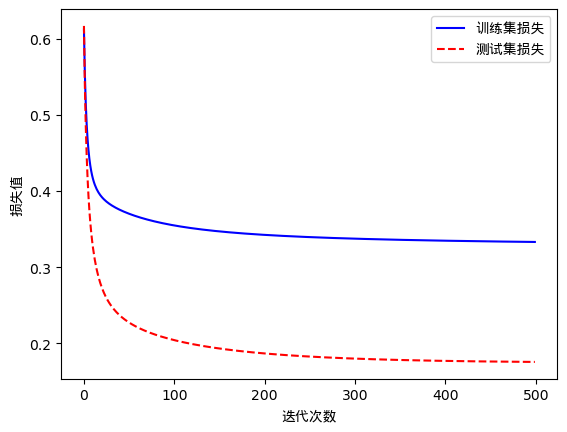

In [13]:
loss_history_test = np.zeros(iterations) # 初始化历史损失
for i in range(iterations): #求训练过程中不同参数带来的测试集损失
    loss_history_test[i] = loss_function(X_test, y_test, weight_history[i], bias_history[i])
index = np.arange(0,iterations,1)
plt.plot(index, loss_history, c='blue', linestyle='solid')
plt.plot(index, loss_history_test, c='red', linestyle='dashed')
plt.legend(["训练集损失", "测试集损失"], prop=myfont)
plt.xlabel("迭代次数", fontproperties=myfont)
plt.ylabel("损失值", fontproperties=myfont)
plt.show() # 同时显示显示训练集和测试集损失曲线



损失曲线告诉我们，对于这个案例，最佳迭代次数是80～100次，才能够让训练集和测试集都达到比较好的预测效果。